In [36]:
from collections import defaultdict
import numpy as np
import random

In [6]:
class Maze():
    def __init__(self, size, blocking_pos, goal):
        """

        :param size: tuple (width, height)
        :param blocking_pos: [(x,y), ...] positions of blocking mazes.
                             Here, expect lower left corner as origin and start from 1
        :param goal: (x,y) position of goal

        Example:
        size = (3,3)
        blocking_pos = [(1,1)]
        goal = (3,3)

        Result Maze:
        0 0 g
        0 0 0
        1 0 0
        where 1 is blocking block and g is the goal
        """
        self.width, self.height = size
        self.blocking_pos = blocking_pos
        self.goal = goal

    def step(self, current_state, action):
        """
        :param current_state: (x,y) current pos
        :param action: action from ['up', 'down', 'right', 'left']
        :return: reward, next_state
        """
        x, y = current_state
        dx, dy = 0, 0
        if action == 'up':
            dy = 1
        elif action == 'down':
            dy = -1
        elif action == 'left':
            dx = -1
        elif action == 'right':
            dx = 1
        else:
            raise ValueError

        # make sure they are in bound
        x_change = max(self.width, min(0, x+dx))
        y_change = max(self.height, min(0, y+dy))

        # make sure they are not blocked
        if (x_change, y_change) in self.blocking_pos:
            # rollback
            x_change, y_change = x,y

        # check goal
        if (x_change, y_change) == self.goal:
            reward = 0
        else:
            reward = 1

        return reward, (x_change, y_change)

In [41]:
class DynaQ:
    def __init__(self, alpha=0.1, gamma=0.95, eps=0.1, planning_n = 50):
        self.alpha = alpha
        self.gamma = gamma
        self.eps = eps
        self.planning_n = planning_n
        self.action_space = ['up', 'down', 'right', 'left']
        self.model = defaultdict(int)
        self.state_encountered = {}
        self.Q = defaultdict(int)
        # key in both Q and model: tuple((x,y),a)

    def greedy(self, state):
        Q_list = [self.Q[state,a] for a in self.action_space]
        return self.action_space[np.argmax(Q_list)]

    def eps_greedy(self, state):
        if np.random.random() > self.eps:
            return self.greedy(state)
        else:
            # return a random action
            return np.random.choice(self.action_space)

    def update(self, state, action, next_state, reward):
        greedy_action = self.greedy(next_state)
        self.Q[state,action] += self.alpha*(reward + self.gamma*self.Q[next_state,greedy_action] - self.Q[state,action])

    def model_update(self, state, action, next_state, reward):
        self.model[state,action] = reward, next_state

    def planning(self):
        for _ in range(self.planning_n):
            state, action = random.sample(self.model.keys(), 1)[0]
            reward, next_state = self.model[state,action]
            self.update(state, action, next_state, reward)

In [ ]:
import matplotlib.pyplot as plt
agent = DynaQ()
# set env the one in Figure 8.2 of the book
env = Maze(size = (9,6), blocking_pos=[(3,3), (3,4), (3,5), (6,2), (8,4), (8,5), (8,6), (8,7)], goal = (9,6))
EPISODE = 50
hist = []
for episode in range(EPISODE):
    state = (1,4)
    for step in range(100000):
        action = agent.eps_greedy(state)
        reward, next_state = env.step(state,action)
        # direct learn
        agent.update(state, action, next_state, reward)
        agent.model_update(state, action, next_state, reward)
        agent.planning()
        state = next_state
        if reward == 1:
            hist.append(step)
            break

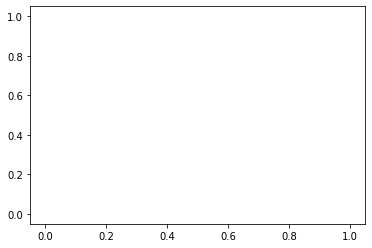

In [28]:
plt.plot(hist)